In [131]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization,Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError,categorical_crossentropy,sparse_categorical_crossentropy,binary_crossentropy
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, Accuracy
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE


In [132]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\mrtat\Downloads\xray_dataset_covid19\train",
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical'  # or 'int', 'binary'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\mrtat\Downloads\xray_dataset_covid19\test",
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical'  # or 'int', 'binary'
)

Found 148 files belonging to 2 classes.


Found 40 files belonging to 2 classes.


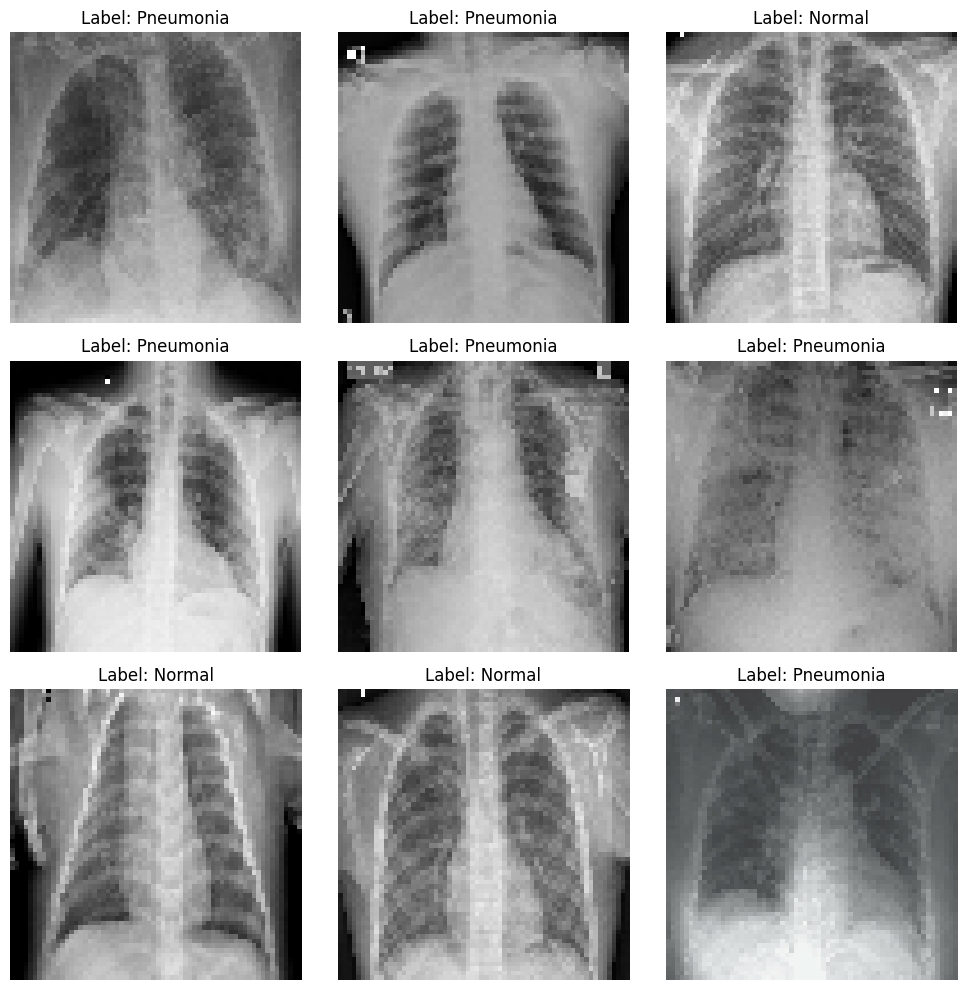

In [133]:
# Get one batch of data
images, labels = next(iter(train_ds))

# Class mapping: index to name
class_names = ["Normal", "Pneumonia"]

# Plot 9 images with readable labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    # Convert one-hot to class index (0 or 1)
    class_index = tf.argmax(labels[i]).numpy()
    class_name = class_names[class_index]

    plt.title(f"Label: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [134]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(2, activation='softmax')  # One-hot output for 2 classes
    ])


    model.compile(
        optimizer=Adam(), 
        loss='binary_crossentropy',       # For one-hot labels
        metrics=['accuracy']
    )

    return model

In [135]:
model=build_model()
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,482 (2.64 MB)

 Trainable params: 692,034 (2.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [136]:
print("\nTraining the model...")
history=model.fit(
    train_ds,
    epochs=50,
    batch_size=32,
    validation_data=test_ds,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Training the model...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.8446 - loss: 0.4259 - val_accuracy: 0.5000 - val_loss: 6.4437
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.9257 - loss: 0.2198 - val_accuracy: 0.5000 - val_loss: 3.4233
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9662 - loss: 0.1709 - val_accuracy: 0.5000 - val_loss: 3.5077
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.9730 - loss: 0.0907 - val_accuracy: 0.5000 - val_loss: 3.5894
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.9932 - loss: 0.0651 - val_accuracy: 0.5000 - val_loss: 3.2659
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.9932 - loss: 0.0390 - val_accuracy: 0.5000 - val_loss: 2.1575
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.9932 - loss: 0.0256 - val_accuracy: 0.5250 - val_loss: 1.1897
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.9932 - loss: 0.0188 - val_accur

Text(0.5, 1.0, 'Model Loss')

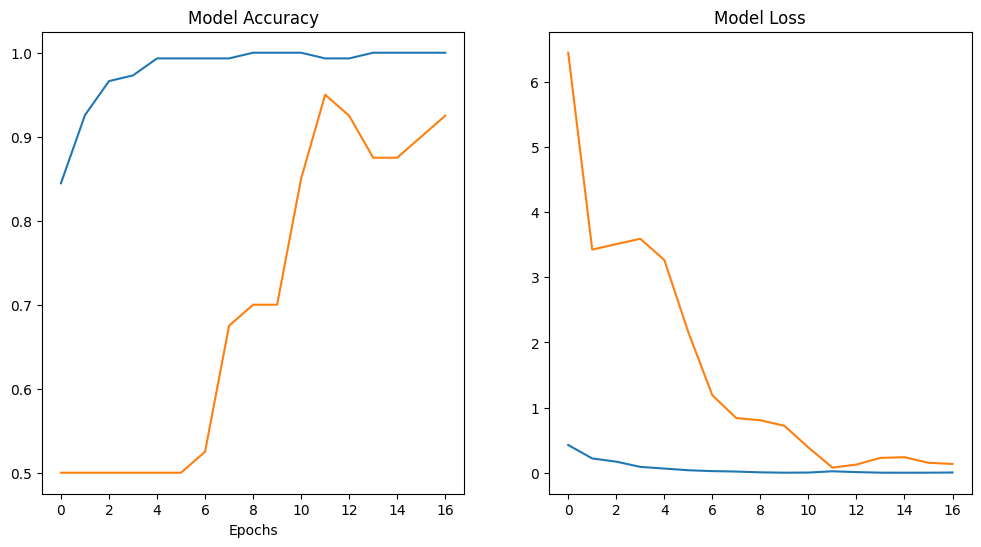

In [137]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')

In [138]:
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1 # +1 becuase index start with 0
print(f"\nBest epoch was: {best_epoch}")


Best epoch was: 12


In [140]:
model.save('my_model.h5')